# **Project: Titanic - Machine Learning From Disaster**
**Serkan Burak Örs**

In [16]:
#!pip install pandas scikit-optimize scikit-learn seaborn matplotlib numpy

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from skopt.plots import plot_convergence
import seaborn as sns
from functools import partial
from skopt import space
from skopt import gp_minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [18]:
# Load the dataset
train_df = pd.read_csv('./train.csv')

# Drop columns that we don't need
train_df.drop(['PassengerId', 'Name','Ticket','Cabin'], axis=1, inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

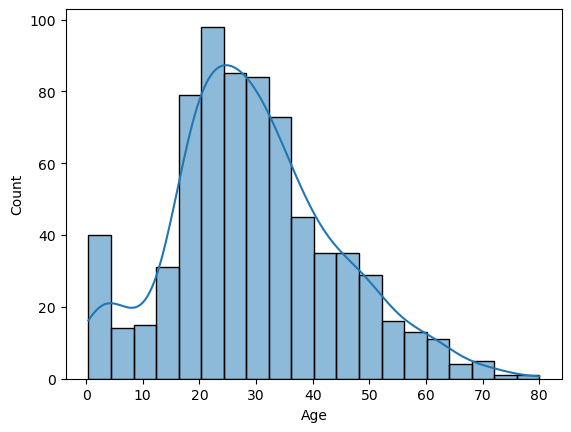

In [19]:
# Histogram for age
sns.histplot(data=train_df, x='Age', kde=True)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

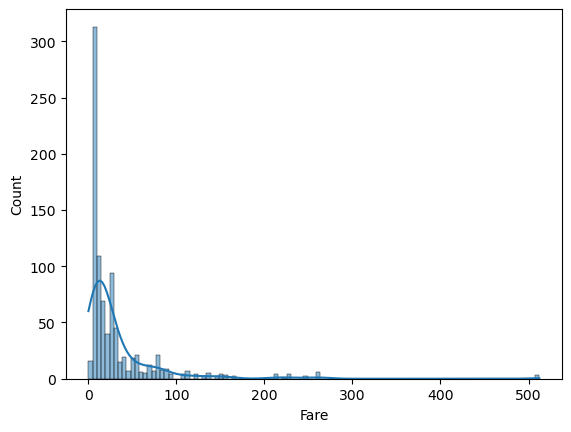

In [20]:
# Histogram for fare
sns.histplot(data=train_df, x='Fare', kde=True) # After replacing missing values with median of age data

<AxesSubplot:xlabel='Embarked', ylabel='count'>

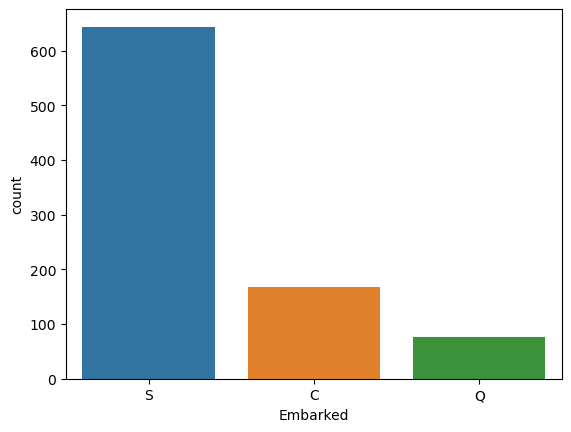

In [21]:
# Count plot for embarking
sns.countplot(data=train_df, x='Embarked')

# Data Preproccession

In [22]:
# Replace missing values with the median or mode
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

# Convert categorical variables to numerical
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Create a new feature 'FamilySize' by combining 'SibSp' and 'Parch'
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Drop the 'SibSp', 'Parch', 'Ticket', and 'Cabin' features
train_df = train_df.drop(['SibSp', 'Parch'], axis=1)

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('Survived', axis=1), 
                                                      train_df['Survived'], 
                                                      test_size=0.2, 
                                                      random_state=42)

<AxesSubplot:xlabel='Age', ylabel='Count'>

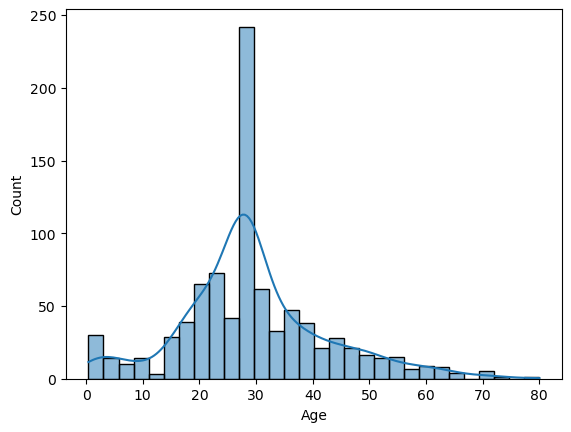

In [23]:
# Histogram for age
sns.histplot(data=train_df, x='Age', kde=True) # After replacing missing values with median of age data

<AxesSubplot:xlabel='Fare', ylabel='Count'>

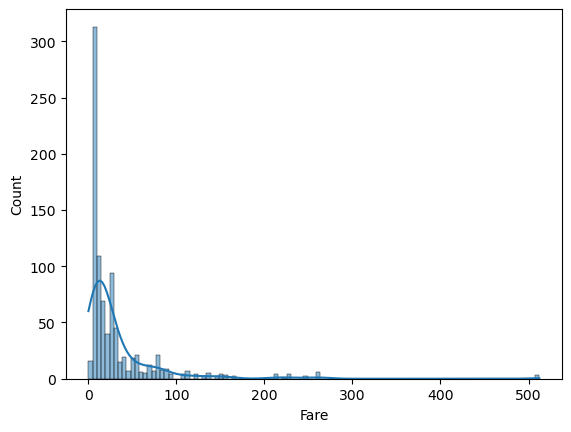

In [24]:
# Histogram for fare
sns.histplot(data=train_df, x='Fare', kde=True) # After replacing missing values with median of fare data

# Implementation of Different Classifiers

In [25]:
# Train and evaluate a decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_valid)
dtc_score = accuracy_score(y_valid, y_pred_dtc)
print('Decision Tree Classifier Accuracy:', dtc_score)

# Train and evaluate a random forest classifier
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_valid)
rfc_score = accuracy_score(y_valid, y_pred_rfc)
print('Random Forest Classifier Accuracy:', rfc_score)

# Train and evaluate a logistic regression classifier with increased max_iter
lor = LogisticRegression(random_state=42, max_iter=1000)
lor.fit(X_train, y_train)
y_pred_lor = lor.predict(X_valid)
lor_score = accuracy_score(y_valid, y_pred_lor)
print('Logistic Regression Classifier Accuracy:', lor_score)

# Support vector machine classifier
svc = SVC(random_state=0)
svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_train)
svc_score = accuracy_score(y_train, svc_y_pred)
print('Support Vector Machine Classifier Accuracy:', svc_score)

Decision Tree Classifier Accuracy: 0.776536312849162
Random Forest Classifier Accuracy: 0.8212290502793296
Logistic Regression Classifier Accuracy: 0.8100558659217877
Support Vector Machine Classifier Accuracy: 0.6783707865168539


In [26]:
# Load the test dataset
test_df = pd.read_csv('./test.csv')
# Drop columns that we don't need
test_df.drop(['PassengerId', 'Name','Ticket','Cabin'], axis=1, inplace=True)
# Check which data set have how many missing values
test_df.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [27]:
# Replace missing values with the median or mode
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Convert categorical variables to numerical
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Create a new feature 'FamilySize' by combining 'SibSp' and 'Parch'
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Drop the 'SibSp', 'Parch', 'Ticket', and 'Cabin' features
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

In [28]:
# Check which data set have how many missing values after preprocession
test_df.isnull().sum()

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
FamilySize    0
dtype: int64

# Optimisation of Hyperparameters
I have used optimisation algorithm within skopt library instead of GridSearchCV from sklearn library, because the former couldn't improve accuracy score as higher as the latter On the other hand, GridSearchCV runs slower than skopt.gp_minimize function.

In [32]:
# Define the hyperparameter search space for RandomForestClassifier
rfc_search_space = [
    space.Integer(1, 100, name='n_estimators'),
    space.Integer(2, 10, name='max_depth'),
    space.Categorical(['gini', 'entropy'], name='criterion'),
    space.Real(0.1, 1.0, name='max_features'),
    space.Integer(2, 20, name='min_samples_split'),
]

# Define the objective function for RandomForestClassifier
def rfc_objective(params, X_train, X_val, y_train, y_val):
    model = RandomForestClassifier(
        n_estimators=params[0],
        max_depth=params[1],
        criterion=params[2],
        max_features=params[3],
        min_samples_split=params[4],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Run hyperparameter optimization for RandomForestClassifier
rfc_objective_fn = partial(rfc_objective, X_train=X_train, X_val=X_valid, y_train=y_train, y_val=y_valid)
rfc_result = gp_minimize(rfc_objective_fn, rfc_search_space, n_calls=100, n_random_starts=100, random_state=42)

# Visualize optimization process
plot_convergence(rfc_result)

# Print the best set of hyperparameters for RandomForestClassifier
print('RandomForestClassifier: ', rfc_result.x)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

DecisionTreeClassifier:  [18, 29, 'gini', 0.9803315837160459, 0.07534625600612822]


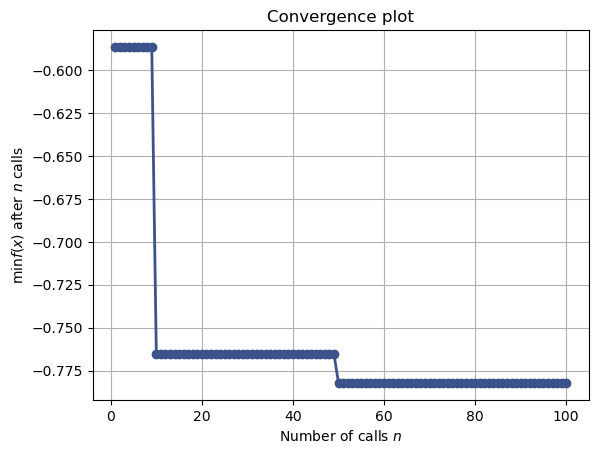

In [15]:
# Define the hyperparameter search space for DecisionTreeClassifier
dt_search_space = [
    space.Integer(2, 50, name='max_depth'),
    space.Integer(2, 50, name='min_samples_split'),
    space.Categorical(['gini', 'entropy'], name='criterion'),
    space.Real(0.0, 1.0, prior='uniform', name='max_features'),
    space.Real(0.0, 1.0, prior='uniform', name='min_impurity_decrease')
]

# Define the objective function for DecisionTreeClassifier
def dt_objective(params, X_train, X_val, y_train, y_val):
    model = DecisionTreeClassifier(
        max_depth=params[0],
        min_samples_split=params[1],
        criterion=params[2],
        max_features=params[3],
        min_impurity_decrease=params[4],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return -accuracy_score(y_val, y_pred)

# Run hyperparameter optimization for DecisionTreeClassifier
dt_objective_fn = partial(dt_objective, X_train=X_train, X_val=X_valid, y_train=y_train, y_val=y_valid)
dt_result = gp_minimize(dt_objective_fn, dt_search_space, n_calls=100, n_random_starts=100, random_state=42)

# Visualize optimization process
plot_convergence(dt_result)

# Print the best set of hyperparameters for DecisionTreeClassifier
print('DecisionTreeClassifier: ', dt_result.x)

In [16]:
# Train a RandomForestClassifier with the optimized hyperparameters
rfcOpt = RandomForestClassifier(n_estimators=rfc_result.x[0],
                                max_depth=rfc_result.x[1],
                                criterion=rfc_result.x[2],
                                max_features=rfc_result.x[3],
                                min_samples_split=rfc_result.x[4],
                                random_state=42
                               )

rfcOpt.fit(X_train, y_train)
y_pred_rfc = rfcOpt.predict(X_valid)
rfcOpt_score = accuracy_score(y_valid, y_pred_rfc)
print('Optimised Random Forest Classifier Accuracy:', rfcOpt_score)

# Train a DecisionTreeClassifier with the optimized hyperparameters
dtcOpt = DecisionTreeClassifier(max_depth=dt_result.x[0],
                                min_samples_split=dt_result.x[1],
                                criterion=dt_result.x[2],
                                max_features=dt_result.x[3],
                                min_impurity_decrease=dt_result.x[4],
                                random_state=42
                               )

dtcOpt.fit(X_train, y_train)
y_pred_dtc = dtcOpt.predict(X_valid)
dtcOpt_score = accuracy_score(y_valid, y_pred_dtc)
print('Optimised Decision Tree Classifier Accuracy:', dtcOpt_score)

Optimised Random Forest Classifier Accuracy: 0.8435754189944135
Optimised Decision Tree Classifier Accuracy: 0.7821229050279329


# I didn't implement cross-validation because when I implement it, it reduced the accuracy score of all methods

<AxesSubplot:>

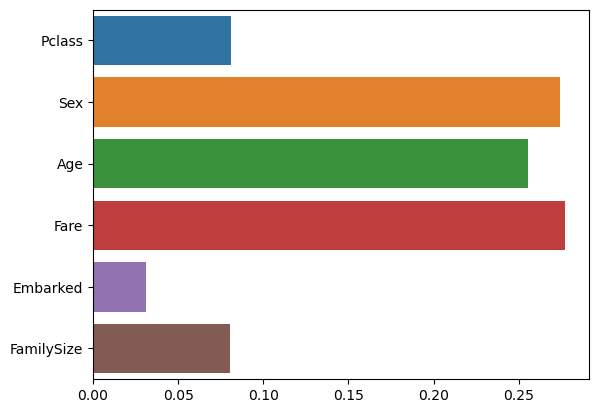

In [17]:
# Plotting of importances of features
importances = rfc.feature_importances_
features = X_train.columns
sns.barplot(x=importances, y=features, orient='h')

In [19]:
# Sort and write highest accurate result 
scores_dict = {'Decision Tree': dtc_score, 'Random Forest': rfc_score, 'SVC': svc_score, 'Logistic Regression': lor_score, 'Random Forest Optimised': rfcOpt_score, 'Decision Tree Optimised': dtcOpt_score}
sorted_scores = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1], reverse=True)}
highest_score = list(sorted_scores.values())[0]
highest_model = list(sorted_scores.keys())[0]

highest_model_obj = None
if highest_model == 'Decision Tree':
    highest_model_obj = dtc
elif highest_model == 'Random Forest':
    highest_model_obj = rfc
elif highest_model == 'SVC':
    highest_model_obj = svc
elif highest_model == 'Logistic Regression':
    highest_model_obj = lor
elif highest_model == 'Random Forest Optimised':
    highest_model_obj = rfcOpt
elif highest_model == 'Decision Tree Optimised':
    highest_model_obj = dtcOpt
print('The most accurate method is', highest_model)

# Make predictions on the test dataset using the method that gives the highest accuracy score
y_pred_test = highest_model_obj.predict(test_df)

# Create a submission file
submission_df = pd.DataFrame({'PassengerId': pd.read_csv('./test.csv')['PassengerId'], 'Survived': y_pred_test})
submission_df.to_csv('titanic.csv', index=False)

The most accurate method is Random Forest Optimised


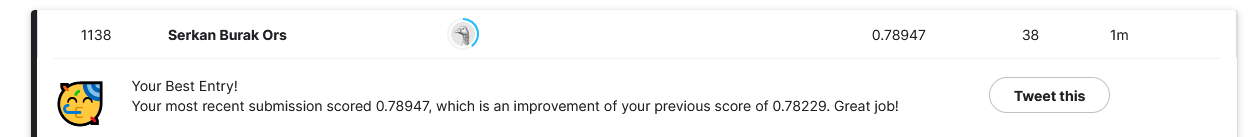

**REFERENCES:**

[1] Goel, Eshita. Applying 7 Classification Algorithms on the Titanic Dataset. url: https://medium.com/geekculture/applying-7-classification-algorithms-on-the-titanic-dataset-278ef222b53c

[2] Orvakanti, Praveen Kumar. This will help you score 95 percentile in the Kaggle Titanic ML competition. url: https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b

[3] Besbes, Ahmed. How to score 0.8134 in Titanic Kaggle. (2018). GitHub Repository, url: https://github.com/charlespwd/project-title https://github.com/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge

[4] Başpınar, Barış. UCK358E Artificial Intelligence Lecture Notes. 2023